## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
from tinnsleep.create_reports import preprocess, reporting
from tinnsleep.scoring import generate_bruxism_report
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from tinnsleep.config import Config

print("config loaded")


config loaded


In [2]:
#Setting parameters
EDF_list = Config.bruxisme_files
THR_classif=[[0,2], [0,3], [0,4], [0,5] , [0,6], [0,7], [0,8], [0,9], [0,10]]
sfreq = 200
window_length = 0.25                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
n_adaptive = 480                        # number of epochs for adaptative baseline
delim = 3                               # maximal time interval between bursts to merge episode in seconds
#Importing personnalized parameters for dataset
df = pd.read_pickle("data/valid_chans_THR_imp.pk")
dico_chans= df.to_dict("list")
print("parameters set")


parameters set


## Processing of the dataset and report generation

In [3]:
import warnings
from time import time
EDF_list=['E:/Acou_sommeil/EDF_V2_PAUL\\sophie_mema.edf']

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    results={}
    print("Files processed: ")
    start = time()
    for filename in EDF_list:
        #opens the raw file
        raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
        file = filename.split(os.path.sep)[-1]
        print(file, end=" ")
        #Get channels indexes
        ind_picks_chan= dico_chans[file][0]
        ind_picks_imp= dico_chans[file][1]
        #Get THR_imp value for filename
        THR_imp = dico_chans[file][2]
        
        #Get channel names from indexes
        if len(ind_picks_chan)>0: #ignore file if no channel is good
            picks_chan=[]
            for elm in ind_picks_chan:
                picks_chan.append(raw.info["ch_names"][elm])
            picks_imp=[]
            for elm in ind_picks_imp:
                picks_imp.append(raw.info["ch_names"][elm])
            #Setting parameters for is_good
            params = dict(ch_names=picks_chan,
                  rejection_thresholds=dict(emg=1e-04),  # two order of magnitude higher q0.01
                  flat_thresholds=dict(emg=1e-09),  # one order of magnitude lower median
                  channel_type_idx=dict(emg=[ i for i in range(len(picks_chan))]),
                  full_report=True
                  )
            # Get the preprocessing steps done
            print("preprocess...", end=" ");tmp = time()
            epochs, valid_labels, log = preprocess(raw, picks_chan, picks_imp, duration, interval, params, THR_imp=THR_imp, get_log=True)
            print(f"DONE ({time()-tmp:.2f}s)", end=" ")
            #If at least one epoch is good create report
            print("report...", end=" ");tmp = time()
            if np.sum(valid_labels)>0 :
                results[filename] = reporting(epochs, valid_labels, THR_classif, time_interval=window_length, delim=delim, n_adaptive = n_adaptive, log=log, generate_report=generate_bruxism_report)
                print(f"DONE ({time()-tmp:.2f}s)")
            else:
                print(f"INVALID ({time()-tmp:.2f}s)")
print(f"Reports created, process finished in {(time()-start)/60:.1f} min")

Files processed: 
sophie_mema.edf preprocess... DONE (19.89s) report... DONE (139.97s)
Reports created, process finished in 2.7 min


In [4]:
for elm in results.keys():
    print(len(results[elm]["reports"]))

9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


## Saving results

In [5]:
df = pd.DataFrame.from_dict(results)
df.to_pickle("data/reports_and_datas_bruxism.pk")

## Data visualization for the entire cohort for nb episodes per hour as a function of THR_classif value : 

Text(0, 0.5, 'Nb of episodes per hour')

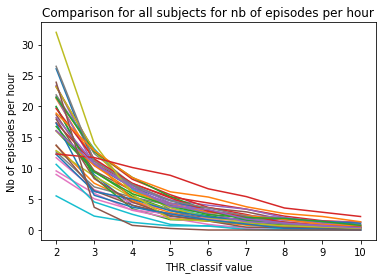

In [6]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Number of episodes per hour"])
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean data duration"])
    plt.plot([i+2 for i in range(9)], nb_ep)
plt.title('Comparison for all subjects for nb of episodes per hour')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')


## Data visualization for the entire cohort for nb bursts as a function of THR_classif value : 

Text(0, 0.5, 'Nb of burst on the recording')

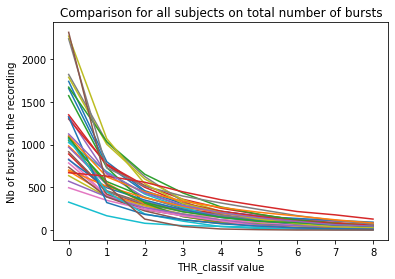

In [7]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Total number of burst"])
    #print(f"Number of bursts for each THR_classif for {elm[-19:]} : {nb_ep}")
    st = elm.split(os.path.sep)[-1] + " len " + str(ep["Clean data duration"])
    plt.plot(nb_ep)
plt.title('Comparison for all subjects on total number of bursts')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of burst on the recording')

## Logs of the preprocessing : 

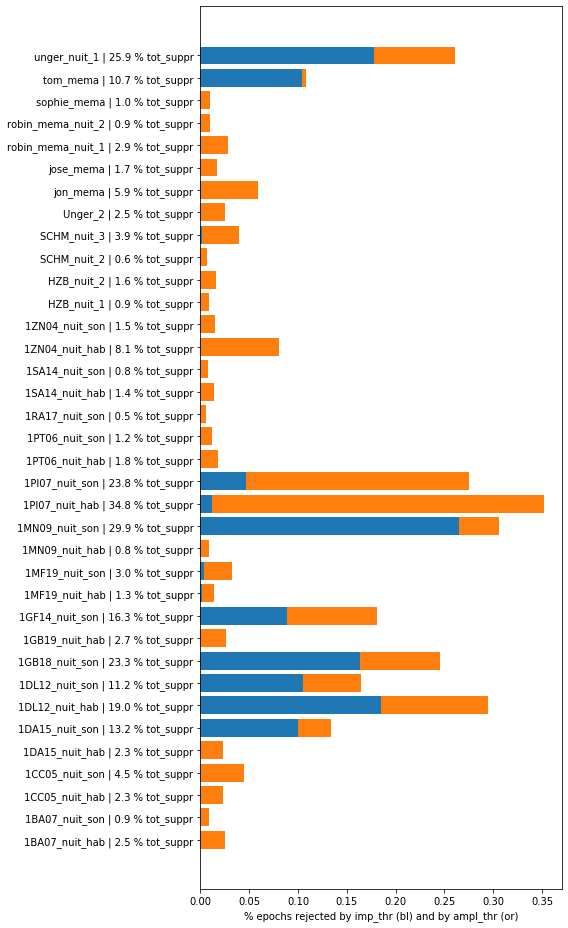

In [8]:
file=[]
suppr_imp=[]
suppr_amp=[]
for elm in results.keys():
    if results[elm]["log"]['suppressed_overall']/results[elm]["log"]['total_nb_epochs'] > 0.0001:
        file.append(elm.split(os.path.sep)[-1][:-4] + " | " + 
                    str("%.1f" % (100 *results[elm]["log"]['suppressed_overall']/results[elm]["log"]['total_nb_epochs']))
                   + " % tot_suppr")
        suppr_imp.append((results[elm]["log"]['suppressed_imp_THR']/results[elm]["log"]['total_nb_epochs']))
        suppr_amp.append(results[elm]["log"]['suppressed_amp_THR']/results[elm]["log"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or)")
plt.tight_layout()
plt.show()


## Extracting list of nb of episodes per hour for all THR_classif per patient

In [9]:
get_scores=[]
for elm in results.keys():
        #print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            l_ep_h.append(ep["Number of episodes per hour"])

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores[-3:])

36
[['sophie_mema.edf', [12.304350603718136, 11.729380949338784, 10.1194659170766, 8.854532677442023, 6.6696479908004855, 5.404714751165911, 3.564811857151984, 2.874848271896761, 2.1848846866415386]], ['tom_mema.edf', [16.09652235628105, 10.731014904187367, 6.8985095812633075, 3.8325053229240598, 3.321504613200852, 1.7885024840312278, 1.1497515968772178, 0.63875088715401, 0.38325053229240597]], ['unger_nuit_1.edf', [23.923044751150147, 3.6804684232538687, 0.7528230865746549, 0.25094102885821834, 0.0, 0.0, 0.0, 0.0, 0.0]]]


## Getting masking, VAS-Loudness and  VAS-Intrusiveness data

In [10]:
get_masking = pd.read_csv("data/evol_masquage.csv", delimiter=";")
#print(get_masking)
get_VAS_L = pd.read_csv("data/evol_eva_I.csv", delimiter=";")
#print(get_VAS_L)
get_VAS_I = pd.read_csv("data/evol_eva_G.csv", delimiter=";")
#print(get_VAS_I)

evol_masking = get_masking.values.tolist()[:-4]
evol_VAS_L = get_VAS_L.values.tolist()
evol_VAS_I = get_VAS_I.values.tolist()



## Comparing nb_ep/hour between patients with tinnitus increase (augm) and without (stable) for values of THR_classif

Nb_patients in each group : 
Tinnitus increase : 13
Tinnitus stable : 16


Text(0, 0.5, 'Nb of episodes per hour')

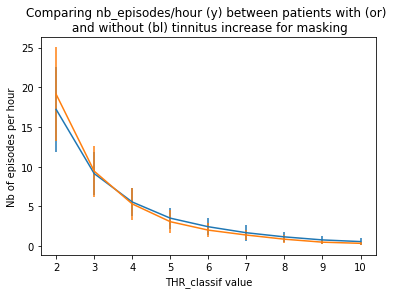

In [11]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for masking" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for absolute overnight evolutions of tinnitus

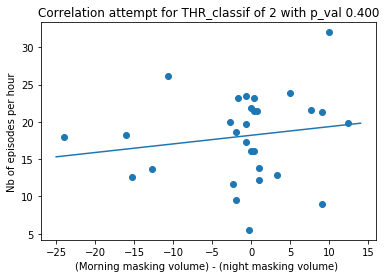

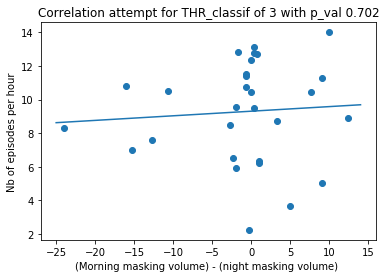

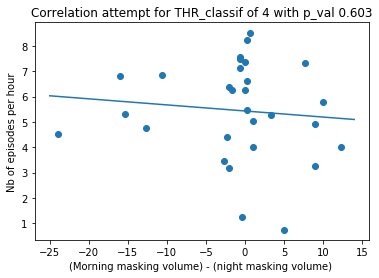

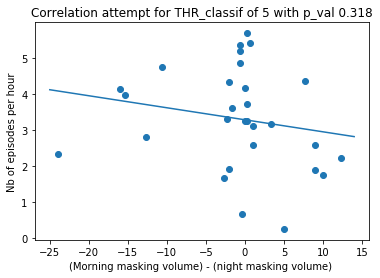

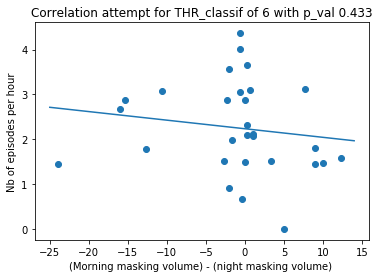

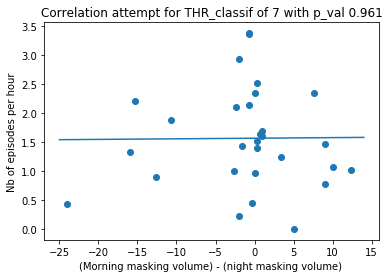

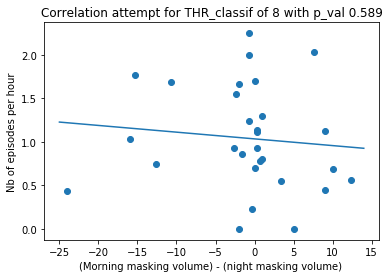

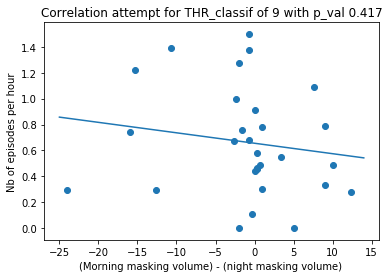

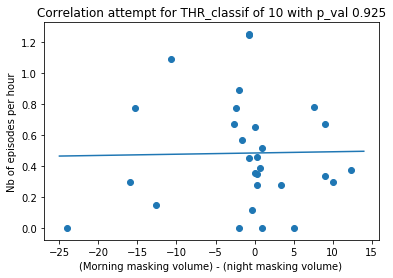

In [12]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for percentage overnight evolutions of tinnitus

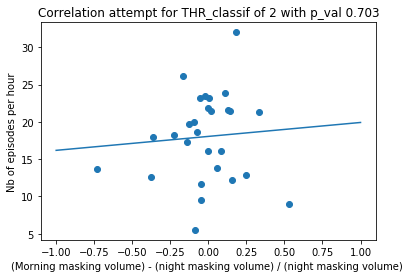

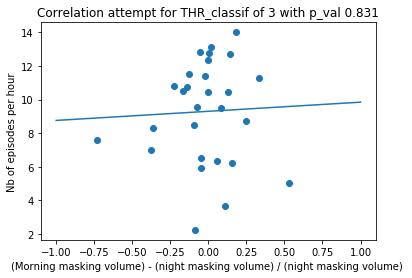

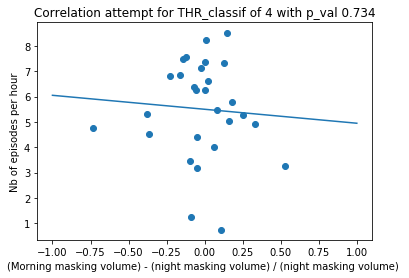

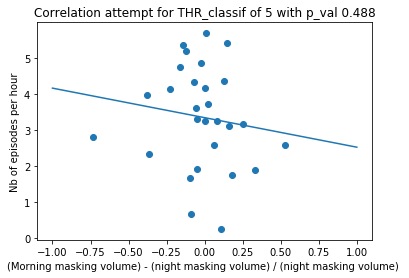

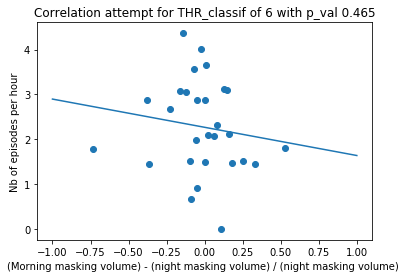

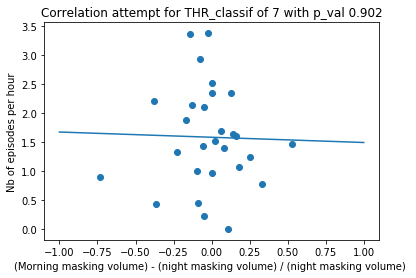

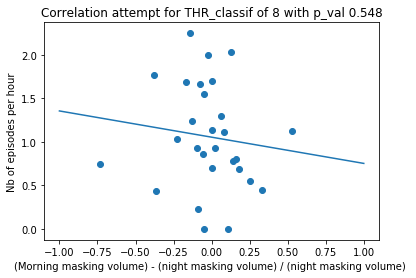

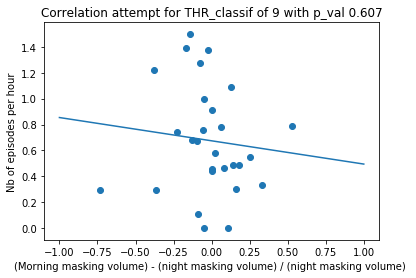

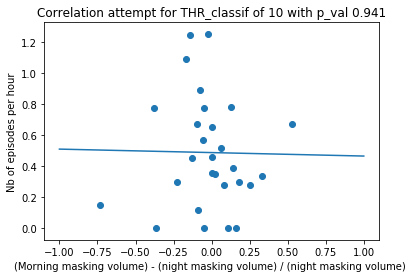

In [13]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) / (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## VAS-L

Nb_patients in each group : 
Tinnitus increase : 6
Tinnitus stable : 24


Text(0, 0.5, 'Nb of episodes per hour')

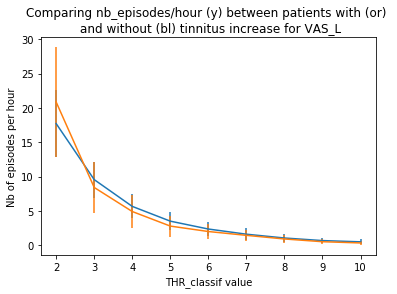

In [14]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_L:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

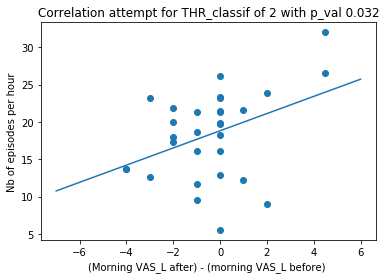

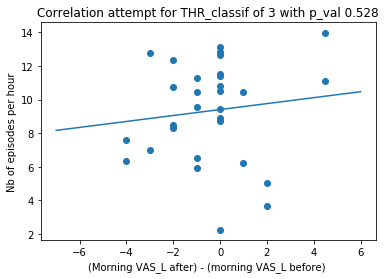

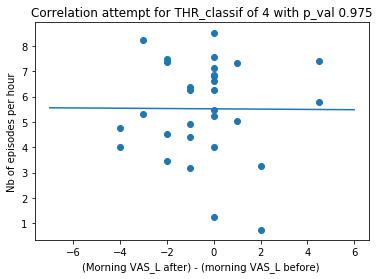

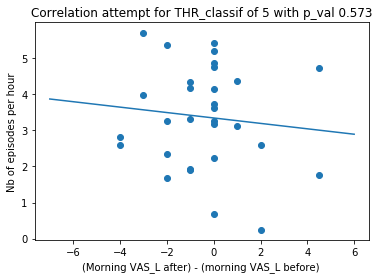

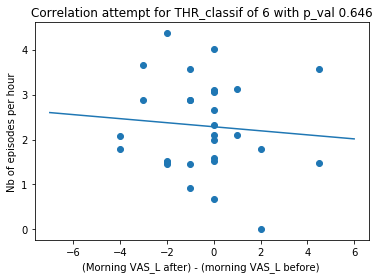

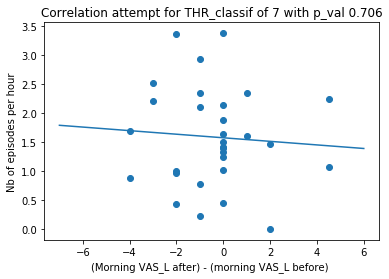

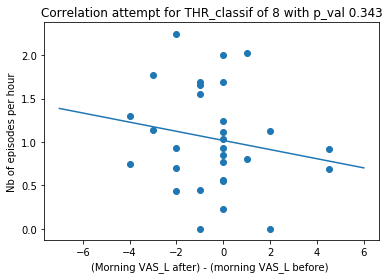

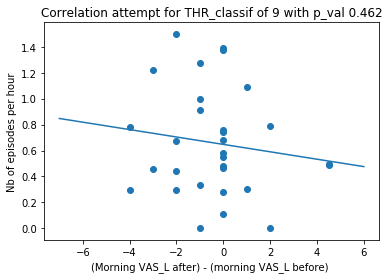

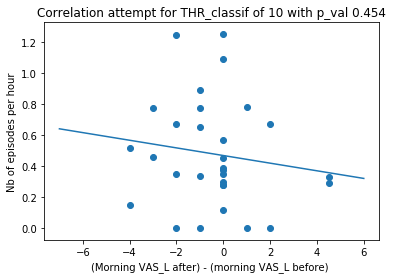

In [15]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

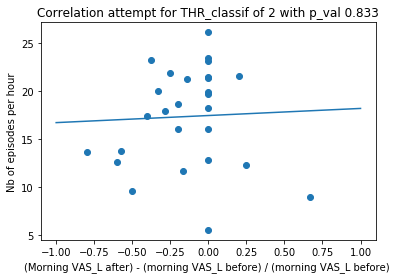

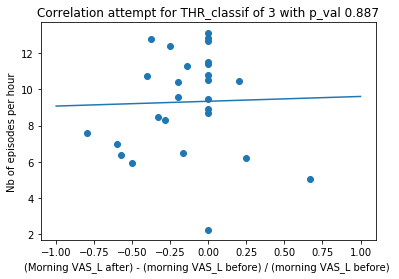

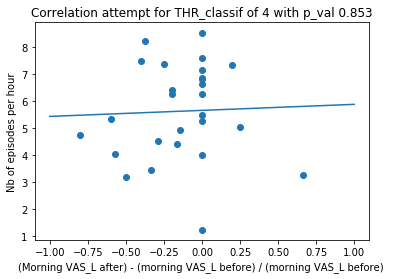

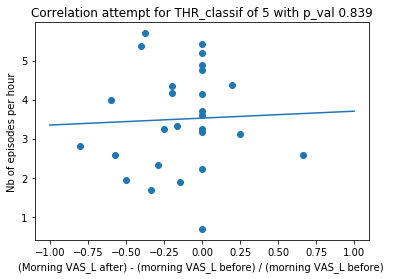

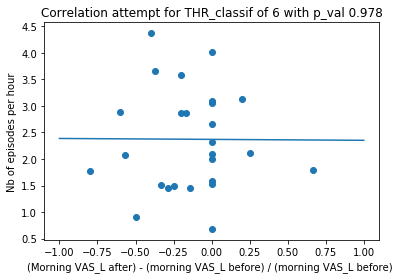

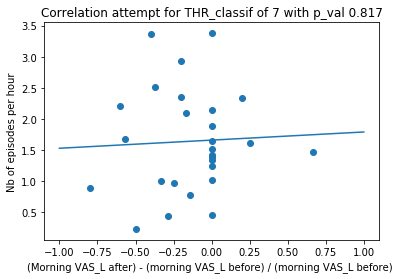

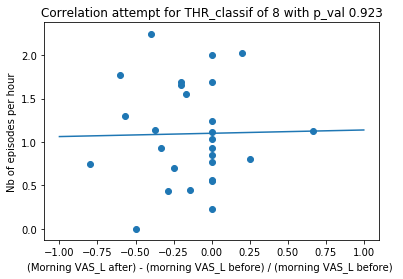

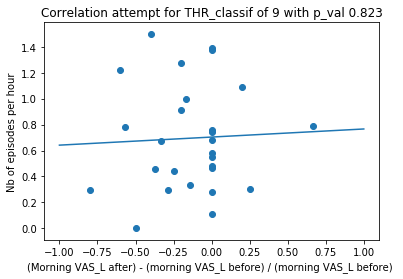

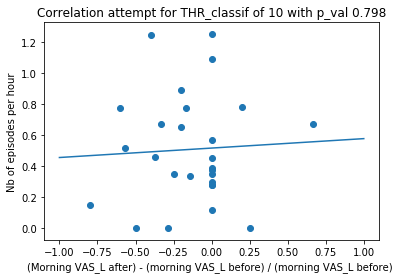

In [16]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_L after) - (morning VAS_L before) / (morning VAS_L before) ')
    plt.ylabel('Nb of episodes per hour')

## VAS_I

Nb_patients in each group : 
Tinnitus increase : 7
Tinnitus stable : 23


Text(0, 0.5, 'Nb of episodes per hour')

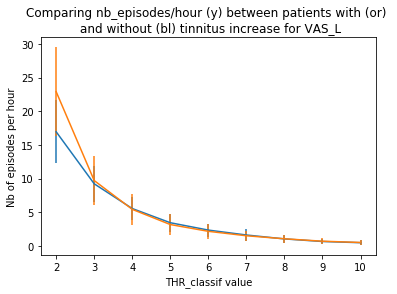

In [17]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_VAS_I:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase for VAS_L" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

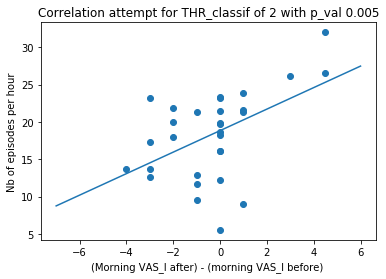

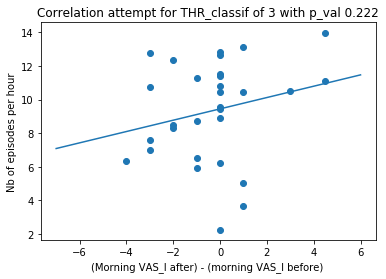

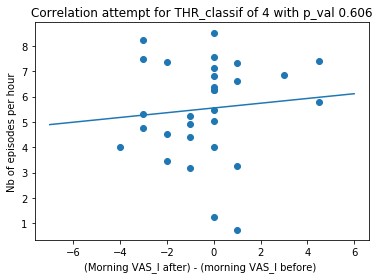

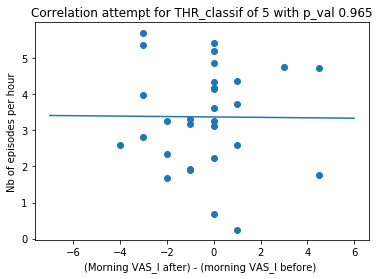

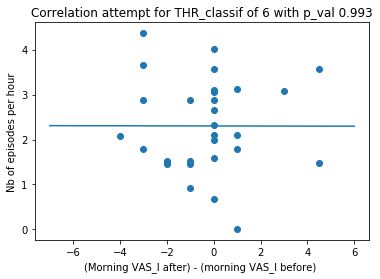

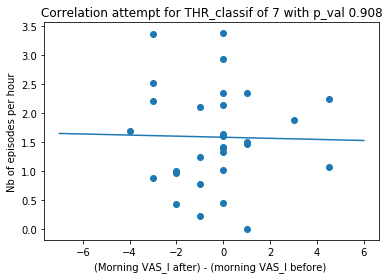

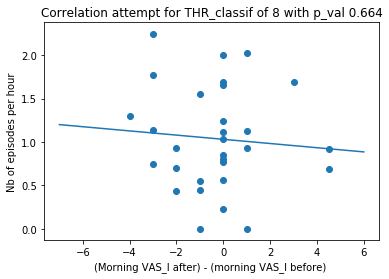

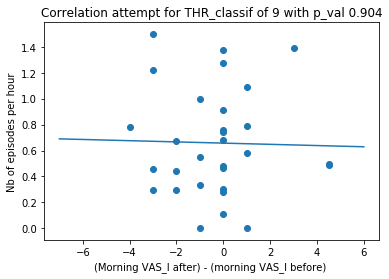

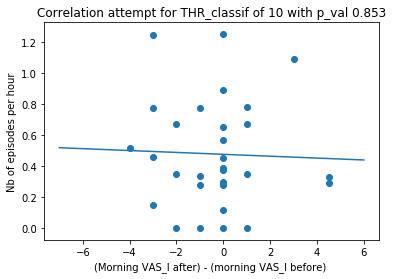

In [18]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-7 for i in range(14)],[intercept + slope *(i-7) for i in range(14)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

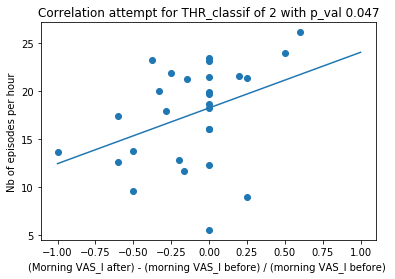

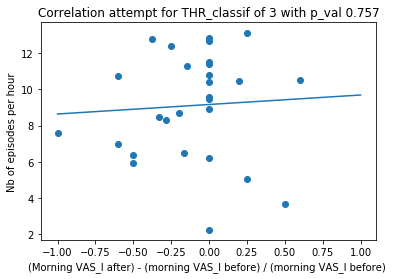

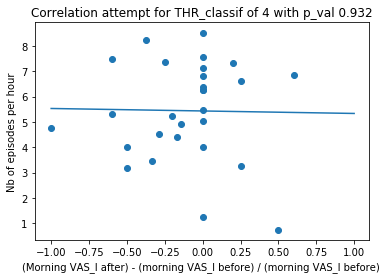

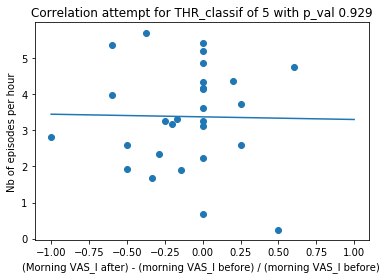

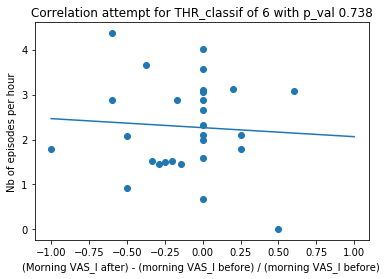

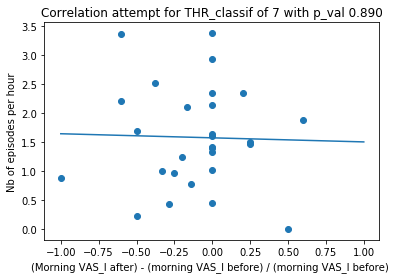

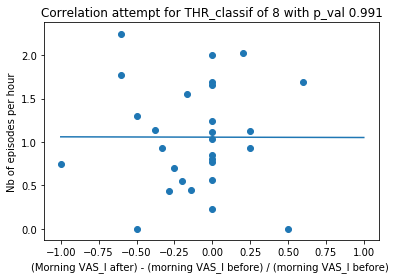

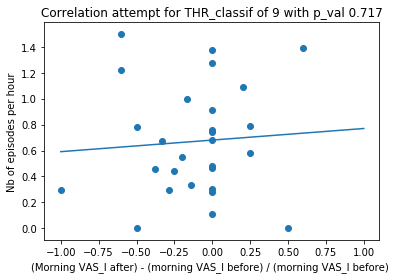

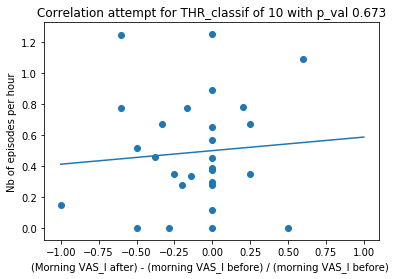

In [19]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning VAS_I after) - (morning VAS_I before) / (morning VAS_I before) ')
    plt.ylabel('Nb of episodes per hour')

In [20]:
print(results.keys())
print(results["E:/Acou_sommeil/EDF_V2_PAUL\\1BA07_nuit_hab.edf"]["reports"])

dict_keys(['/Users/louis/Data/SIOPI/bruxisme/1BA07_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1BA07_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1CC05_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1CC05_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1DA15_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1DA15_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1DL12_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1DL12_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1GB18_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1GB19_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1GF14_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1MF19_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1MF19_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1MN09_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1MN09_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1PI07_nuit_hab.edf', '/Users/louis/Data/SIOPI/bruxisme/1PI07_nuit_son.edf', '/Users/louis/Data/SIOPI/bruxisme/1PT06_nuit_hab.edf',

KeyError: 'E:/Acou_sommeil/EDF_V2_PAUL\\1BA07_nuit_hab.edf'